In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50, VGG16, InceptionV3
from keras.applications.vgg16 import preprocess_input, decode_predictions
# from utils import make_parallel
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


In [2]:
path = '/home/sysadmin/code/python/catdog_model/data/train/'
label = np.array([0] * 12500 + [1] * 12500)
data = np.zeros((25000, 224, 224, 3), dtype=np.uint8)
i=0
for root,dirs,files in os.walk(path+"/cats")    :
    for filei in files:
        img = cv2.imread(path + '/cats/' + filei)
        img = img[:, :, ::-1]
        img = cv2.resize(img, (224, 224))
        data[i] = img
        i=i+1
    
for root,dirs,files in os.walk(path+"/dogs")    :
    for filei in files:
        img = cv2.imread(path + '/dogs/' + filei)
        img = img[:, :, ::-1]
        img = cv2.resize(img, (224, 224))
        data[i] = img
        i=i+1

print('Training Data Size = %.2f GB' % (sys.getsizeof(data)/1024**3))

Training Data Size = 3.50 GB


In [2]:
path = '/home/sysadmin/code/python/catdog_model/data/train/'
label = []
data = []
i=0
for root,dirs,files in os.walk(path+"/cats")    :
    for filei in files:
        img = cv2.imread(path + '/cats/' + filei)
        
        img = img[:, :, ::-1]
        img = cv2.resize(img, (224, 224))
        label.append(0)
        data.append( img)
    
for root,dirs,files in os.walk(path+"/dogs")    :
    for filei in files:
        img = cv2.imread(path + '/dogs/' + filei)
        img = img[:, :, ::-1]
        img = cv2.resize(img, (224, 224))
        label.append(0)
        data.append( img)
label=np.array(label)
data=np.array(data)
print('Training Data Size = %.2f GB' % (sys.getsizeof(data)/1024**3))

Training Data Size = 3.22 GB


In [3]:
data.shape,label.shape

((23000, 224, 224, 3), (23000,))

In [4]:
X_train, X_val, y_train, y_val = train_test_split(data, label, shuffle=True, test_size=0.2, random_state=42)

In [7]:
from keras import backend as K
from keras.models    import Model
from keras.layers import Flatten, Dense, Dropout, Input, BatchNormalization, Conv2D, MaxPool2D, \
    GlobalAveragePooling2D
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [8]:
from  keras.models import load_model
base_model = load_model("/home/sysadmin/code/python/catdog_model/models-flip/weights-impovement-06--0.94.hdf5",custom_objects={"f1_m": f1_m})

/home/sysadmin/anaconda2/envs/py35keras/lib/python3.5/site-packages/keras/utils/io_utils.py:186: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.data = h5py.File(path,)


In [9]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      9248      
__________

In [10]:

for layers in base_model.layers:
    layers.trainable = False
y = GlobalAveragePooling2D()(base_model.get_layer("conv2d_12").output)
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
from keras import backend as K

def get_params_count(model):
    trainable = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
    return trainable, non_trainable

print('Trainable Parameters: ', get_params_count(model)[0])

Trainable Parameters:  513


In [12]:
from keras.callbacks import LambdaCallback
weights_history = []
get_weights_cb = LambdaCallback(on_batch_end=lambda batch, 
                                logs: weights_history.append(model.layers[-1].get_weights()[0]))

In [ ]:
history = model.fit(x=X_train, y=y_train, 
                    batch_size=16, 
                    epochs=10, 
                    validation_data=(X_val, y_val), 
                    callbacks=[get_weights_cb])

Train on 18400 samples, validate on 4600 samples
Epoch 1/10
18400/18400 [==============================] - 77s 4ms/step - loss: 1.0140e-07 - acc: 1.0000 - val_loss: 1.0007e-07 - val_acc: 1.0000
Epoch 2/10
18400/18400 [==============================] - 80s 4ms/step - loss: 1.0445e-07 - acc: 1.0000 - val_loss: 1.0006e-07 - val_acc: 1.0000
Epoch 3/10
18400/18400 [==============================] - 79s 4ms/step - loss: 8.6945e-04 - acc: 0.9999 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 4/10
18400/18400 [==============================] - 79s 4ms/step - loss: 1.0307e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 5/10
18400/18400 [==============================] - 80s 4ms/step - loss: 1.0027e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 6/10
 2736/18400 [===>..........................] - ETA: 54s - loss: 1.0019e-07 - acc: 1.0000

In [14]:
import pickle
with open('weights_history2-d.p', 'wb') as f:
    pickle.dump(weights_history, f)

In [15]:
with open('weights_history2-d.p', 'rb') as f:
    weights_history = pickle.load(f)

In [16]:
target = data[11][:, :, ::-1]

In [17]:
get_layer_output = K.function([base_model.layers[0].input], [base_model.layers[22].output])

out_base = get_layer_output([np.expand_dims(target, axis=0)])[0]


In [18]:
out_base = out_base[0]


In [19]:
# 根据卷积层输出特征图集和模型某一参数状态计算预测概率（为了简单省略了bias计算）
def predict_on_weights(out_base, weights):
    gap = np.average(out_base, axis=(0, 1))
    logit = np.dot(gap, np.squeeze(weights))
    return 1 / (1 +  np.e ** (-logit))

predict_on_weights(out_base, weights_history[11])

1.938196508020853e-46

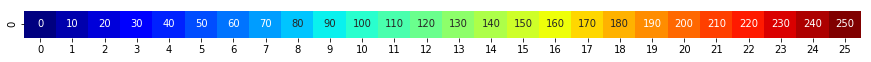

In [20]:
import seaborn as sns
plt.figure(figsize=(15, 0.5))
band = np.array([list(np.arange(0, 255, 10))] * 1)
sns.heatmap(band, annot=True, fmt="d", cmap='jet', cbar=False)
plt.show()

In [21]:
def getCAM(image, feature_maps, weights, display=False):
    
    predict = predict_on_weights(feature_maps, weights)
    
    # Weighted Feature Map
    cam = (predict - 0.5) * np.matmul(feature_maps, weights)
    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    # Resize as image size
    cam_resize = cv2.resize(cam, (224, 224))
    # Format as CV_8UC1 (as applyColorMap required)
    cam_resize = 255 * cam_resize
    cam_resize = cam_resize.astype(np.uint8)
    # Get Heatmap
    heatmap = cv2.applyColorMap(cam_resize, cv2.COLORMAP_JET)
    # Zero out
    heatmap[np.where(cam_resize <= 100)] = 0
    
    out = cv2.addWeighted(src1=image, alpha=0.8, src2=heatmap, beta=0.4, gamma=0)
    out = cv2.resize(out, dsize=(400, 400))
    
    if predict < 0.5:
        text = 'cat %.2f%%' % (100 - predict * 100)
    else:
        text = 'dog %.2f%%' % (predict * 100)
        
    cv2.putText(out, text, (210, 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, 
                  color=(123,222,238), thickness=2, lineType=cv2.LINE_AA)
    if display:
        plt.figure(figsize=(7, 7))
        plt.imshow(out[:, :, ::-1])
        plt.show()
    return out

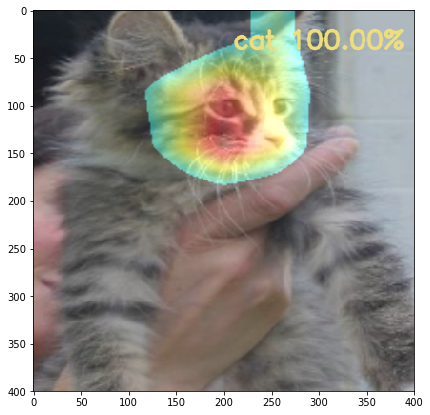

In [22]:
getCAM(image=target, feature_maps=out_base, weights=weights_history[10], display=True);

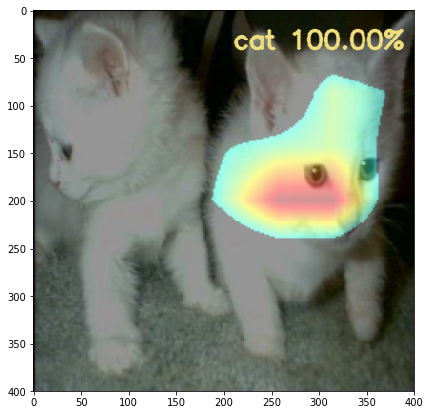

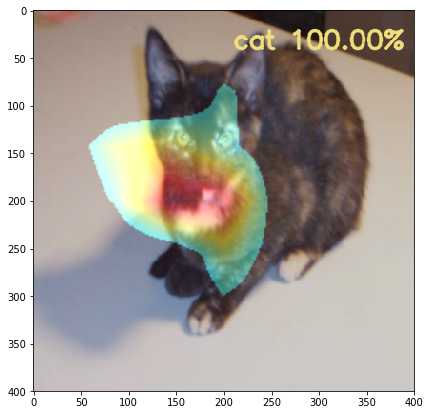

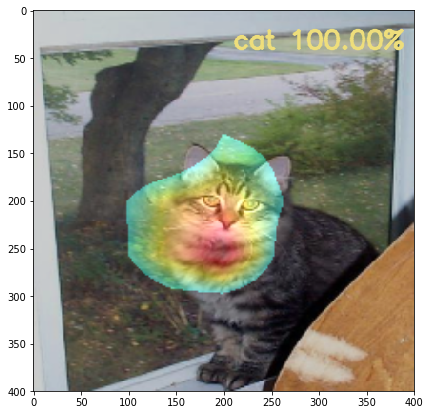

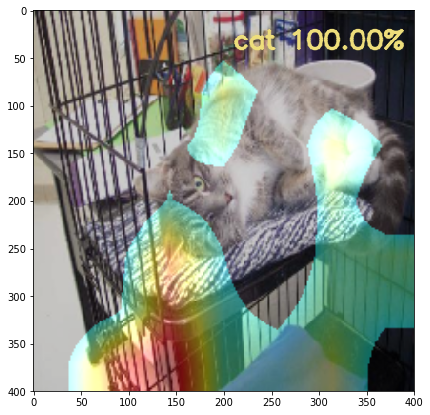

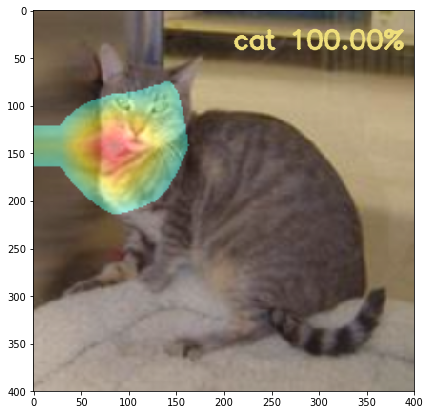

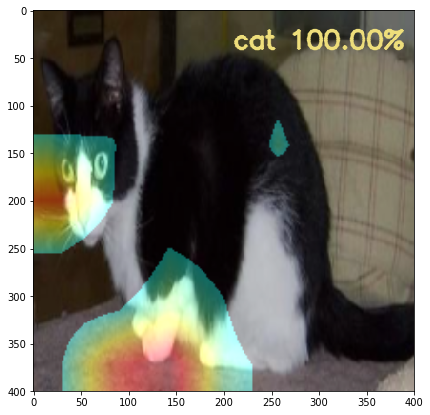

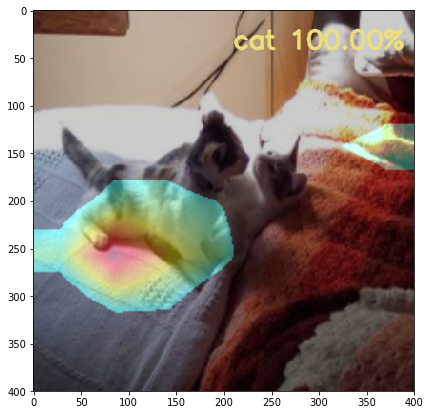

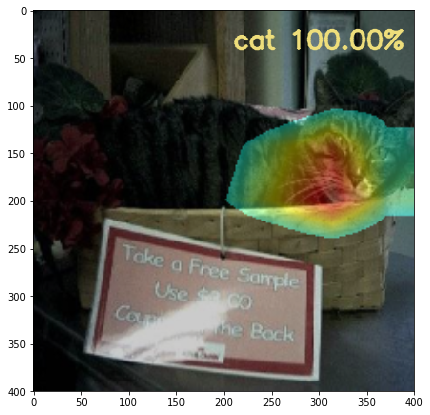

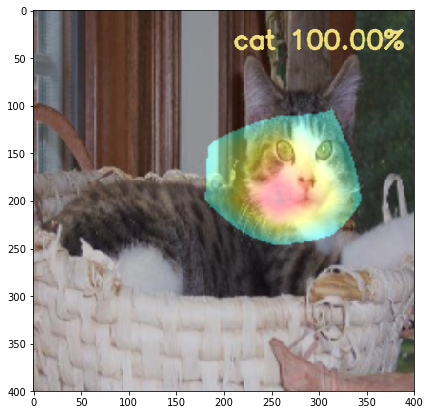

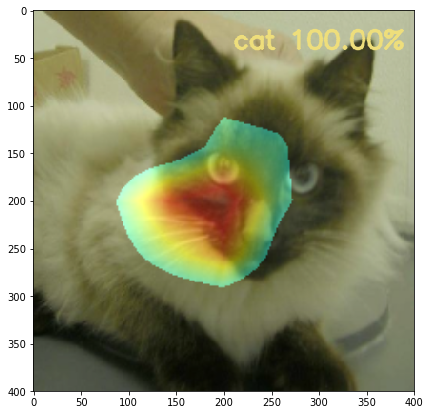

In [23]:
for ii in range(100,110):

    target = data[ii][:, :, ::-1]
    get_layer_output = K.function([base_model.layers[0].input], [base_model.layers[22].output])

    out_base = get_layer_output([np.expand_dims(target, axis=0)])[0]
    out_base = out_base[0]
    getCAM(image=target, feature_maps=out_base, weights=weights_history[ii], display=True);